In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import tensorflow as tf
from skimage.feature import hog

In [2]:
# loading data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# data pre-processing
y_train = train['label'].astype('float32')
X_train = train.drop(['label'], axis=1).astype('int32')
X_test = test.astype('float32')
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

In [4]:
# data pre-processing - reshaping (The first number is the number of images, Then comes the shape of each image (28x28). The last number is 1, which signifies that the images are greyscale.)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
X_train.shape, X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

### Feature engineering using HOG: Histogram of Oriented Gradients

In [5]:
X_train_feature = []
for i in range(len(X_train)):
    feature = hog(X_train[i],orientations=9,pixels_per_cell=(14,14),cells_per_block=(1,1),block_norm="L2")
    X_train_feature.append(feature)
X_train_feature = np.array(X_train_feature,dtype = np.float32)

In [7]:
X_test_feature = []
for i in range(len(X_test)):
    feature = hog(X_test[i],orientations=9,pixels_per_cell=(14,14),cells_per_block=(1,1),block_norm="L2")
    X_test_feature.append(feature)
X_test_feature = np.array(X_test_feature,dtype=np.float32)

In [6]:
# data normalization - dimensionality reduction
# dataset has images with pixel values in the range [0, 255] - for the [0,1] scaling, you simply divide by 255
#X_train = X_train/255.0
#X_test = X_test/255.0

In [8]:
X_train_feature = X_train/255.0
X_test_feature = X_test/255.0

In [ ]:
#count images by label
sns.countplot(x='label', data=train);

In [ ]:
train.head()

In [9]:
# one-hot encoding - create a column for each output category and a binary variable is inputted for each category
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 10)
y_train.shape

(42000, 10)

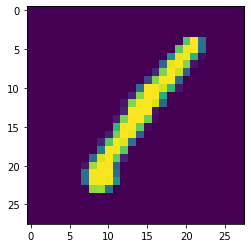

In [121]:
# plot the first image in the dataset
plt.imshow(X_train[0])

In [122]:
#check image shape
X_train[0].shape

(28, 28, 1)

In [123]:
# splitting test and train datasets with 10% for test
# from sklearn.model_selection import train_test_split
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

## Building a Convolutional Neural Network (CNN) in Keras
### Sequential model

In [10]:
# sequential allows you to build a model layer by layer.
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

* Our first 2 layers are Conv2D layers. These are convolution layers that will deal with our input images, which are seen as 2-dimensional matrices.
* 64 in the first layer and 32 in the second layer are the number of nodes in each layer. This number can be adjusted to be higher or lower, depending on the size of the dataset. In our case, 64 and 32 work well, so we will stick with this for now.

* Kernel size is the size of the filter matrix for our convolution. So a kernel size of 3 means we will have a 3x3 filter matrix. Refer back to the introduction and the first image for a refresher on this.

* Activation is the activation function for the layer. The activation function we will be using for our first 2 layers is the ReLU, or Rectified Linear Activation. This activation function has been proven to work well in neural networks.

* Our first layer also takes in an input shape. This is the shape of each input image, 28,28,1 as seen earlier on, with the 1 signifying that the images are greyscale.

* In between the Conv2D layers and the dense layer, there is a ‘Flatten’ layer. Flatten serves as a connection between the convolution and dense layers.

* ‘Dense’ is the layer type we will use in for our output layer. Dense is a standard layer type that is used in many cases for neural networks.

* We will have 10 nodes in our output layer, one for each possible outcome (0–9).

* The activation is ‘softmax’. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

In [125]:
# compiling the model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# training the model, 7 epochs
#model.fit(X_train, y_train, validation_data=(X_cv,y_cv), epochs=3)

Train on 42000 samples, validate on 4200 samples
Epoch 1/3
42000/42000 [==============================] - 53s 1ms/step - loss: 0.1499 - accuracy: 0.9550 - val_loss: 0.0551 - val_accuracy: 0.9833
Epoch 2/3
42000/42000 [==============================] - 53s 1ms/step - loss: 0.0518 - accuracy: 0.9840 - val_loss: 0.0255 - val_accuracy: 0.9933
Epoch 3/3
42000/42000 [==============================] - 51s 1ms/step - loss: 0.0323 - accuracy: 0.9894 - val_loss: 0.0165 - val_accuracy: 0.9952


In [11]:
# compiling the model with HOG
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# training the model, 7 epochs
model.fit(X_train_feature, y_train, epochs=3)

Epoch 1/3
42000/42000 [==============================] - 52s 1ms/step - loss: 0.1477 - accuracy: 0.9564
Epoch 2/3
42000/42000 [==============================] - 51s 1ms/step - loss: 0.0501 - accuracy: 0.9846
Epoch 3/3
42000/42000 [==============================] - 50s 1ms/step - loss: 0.0336 - accuracy: 0.9894


* Adam is generally a good optimizer to use for many cases. The adam optimizer adjusts the learning rate throughout training.
* The learning rate determines how fast the optimal weights for the model are calculated. 
* We will use ‘categorical_crossentropy’ for our loss function. This is the most common choice for classification. A lower score indicates that the model is performing better.
* We will use the ‘accuracy’ metric to see the accuracy score on the validation set when we train the model.

In [13]:
# using our model to make predictions
y_pred = model.predict(X_test_feature)
y_pred = np.argmax(y_pred,axis=1)
# saving submission for kaggle
my_submission = pd.DataFrame({'ImageId': list(range(1, len(y_pred)+1)), 'Label': y_pred})
my_submission.to_csv('submission.csv', index=False)

## Accuracy

Adam optimizer 10 epochs : 0.98157

Adam optimizer 3 epochs: 0.98328

HOG + Adam optimizer 3 epochs: 0.98471

- USE TEST DS
- Посмотреть точность с feature engeneering:

    HOG: Histogram of Oriented Gradients
    SIFT: Scale Invariant Feature Transform
    SURF: Speeded-Up Robust Feature
